c:\Users\yogin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e+05, tolerance: 1.709e+04
  model = cd_fast.enet_coordinate_descent(


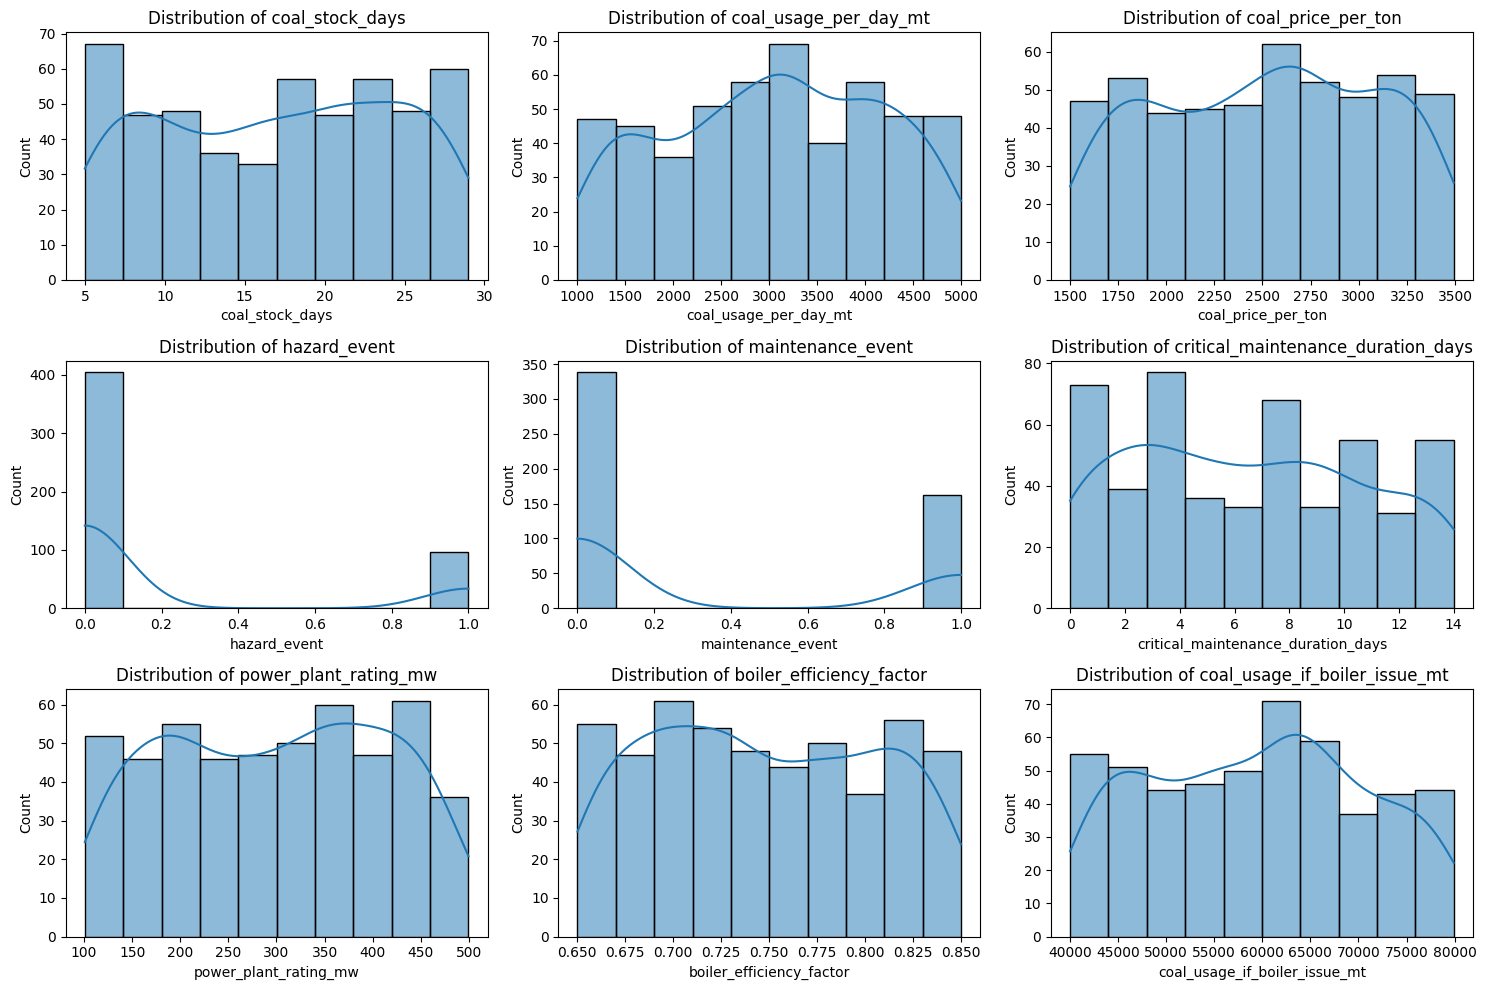

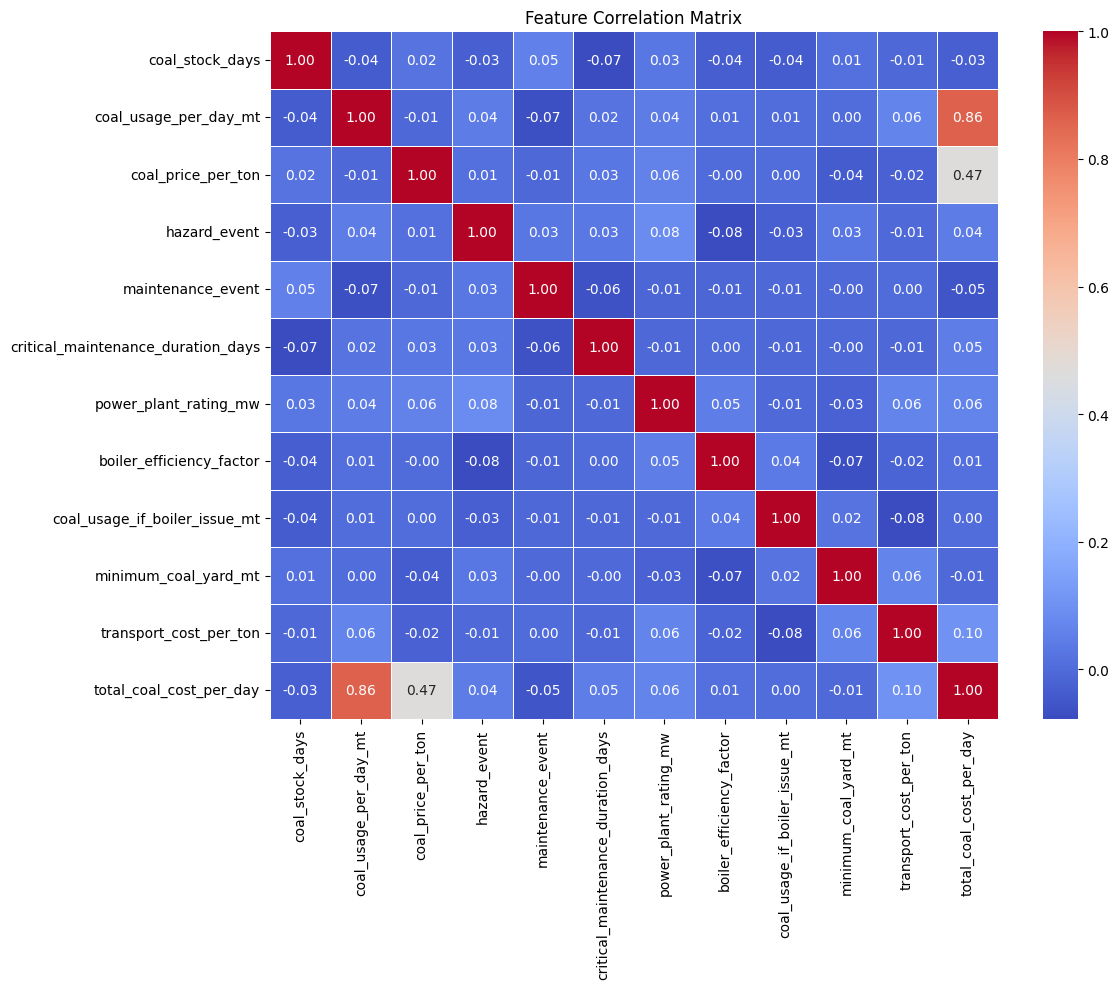

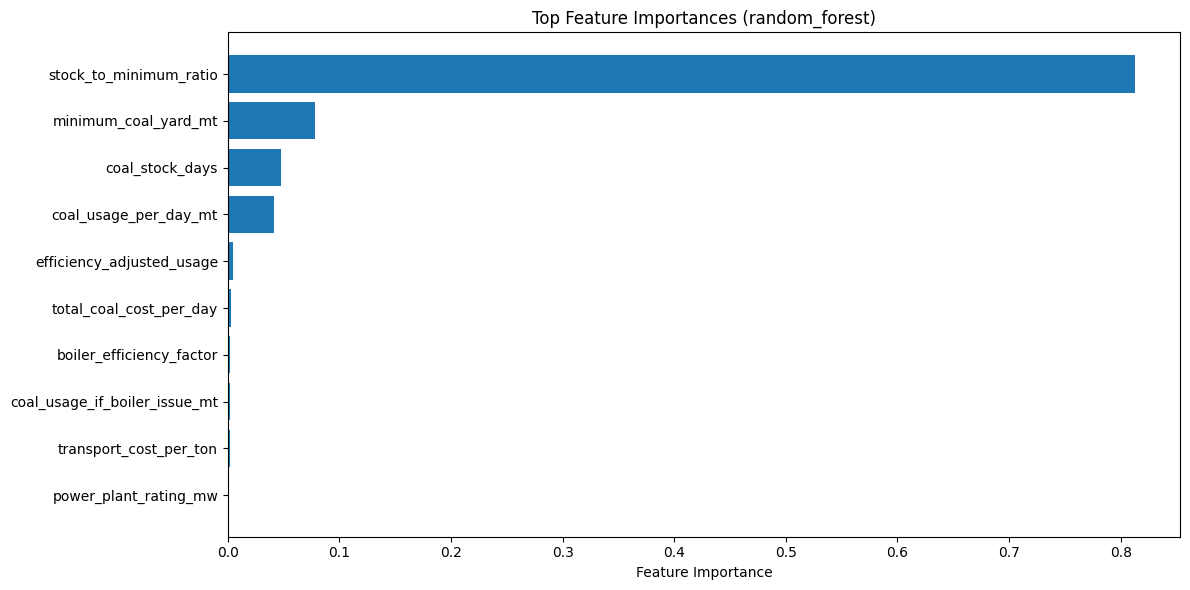

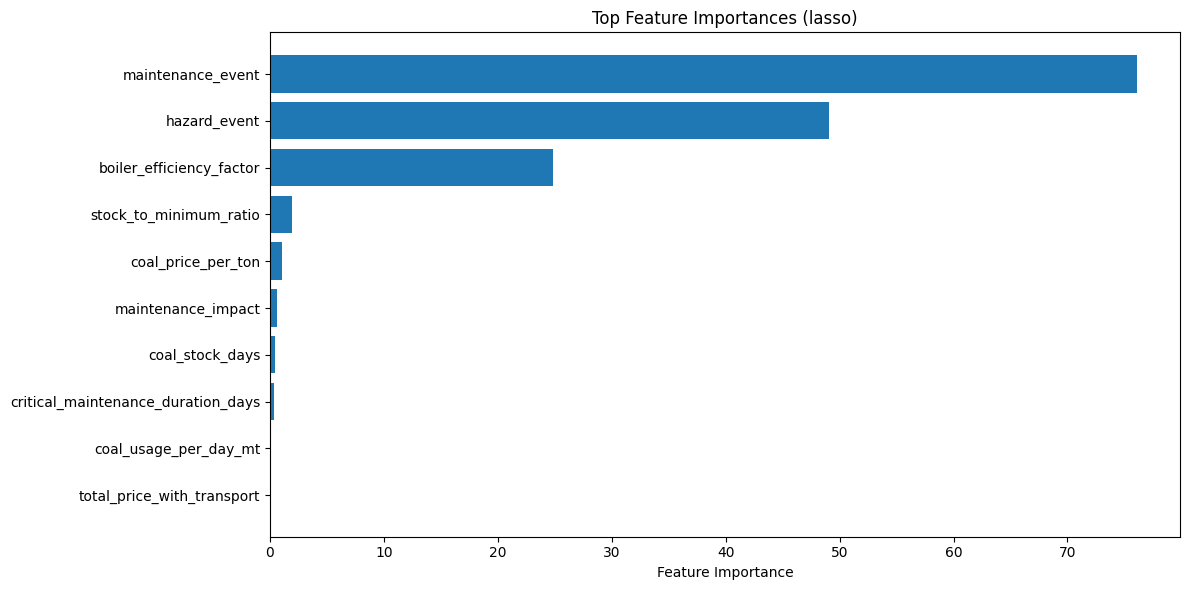

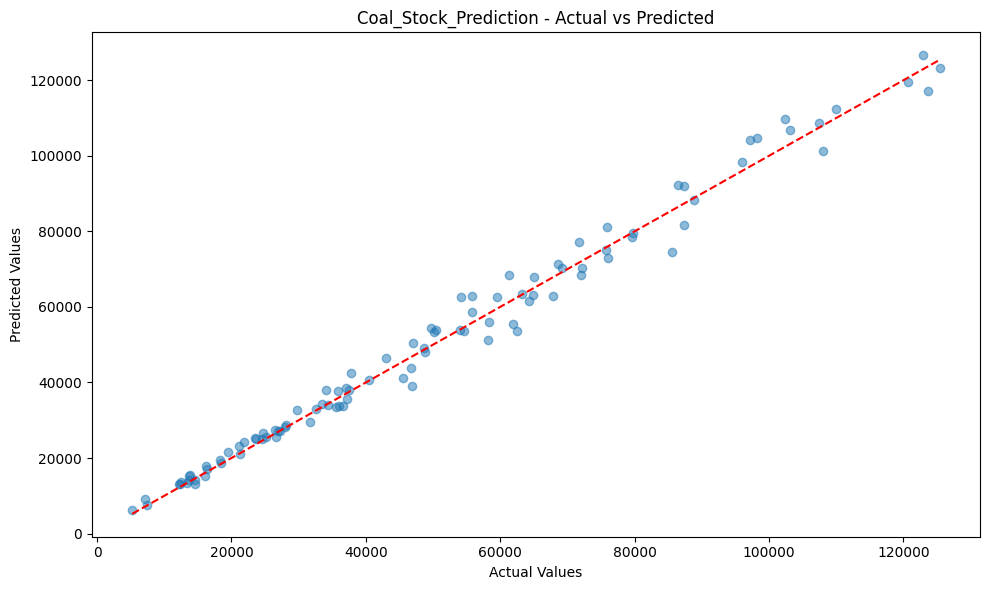

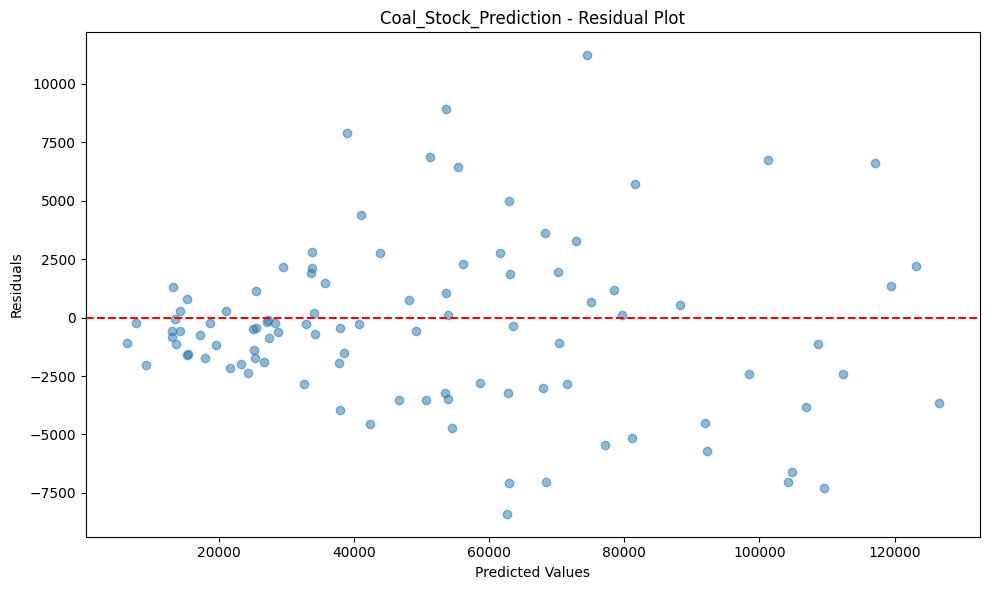

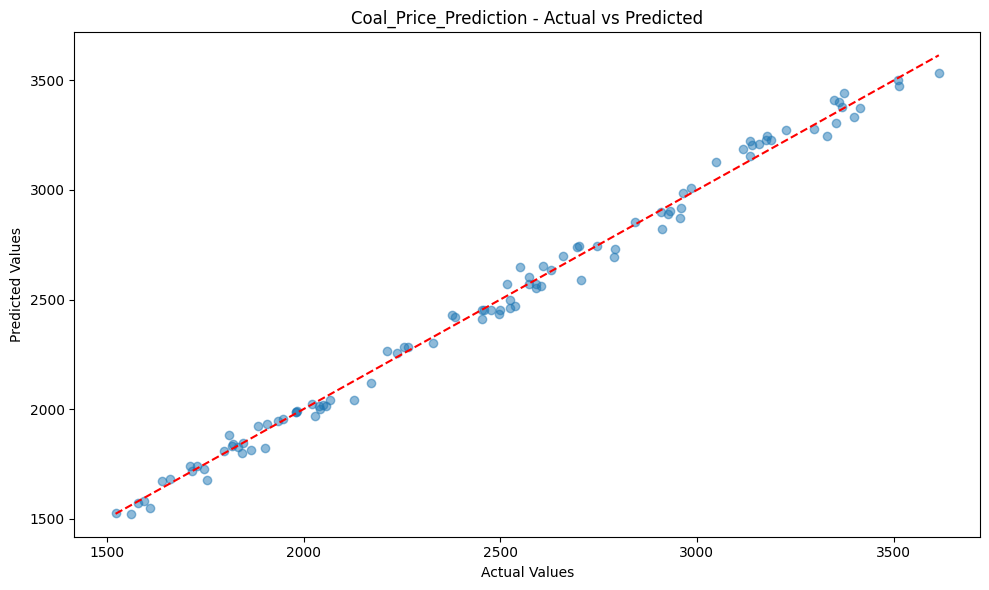

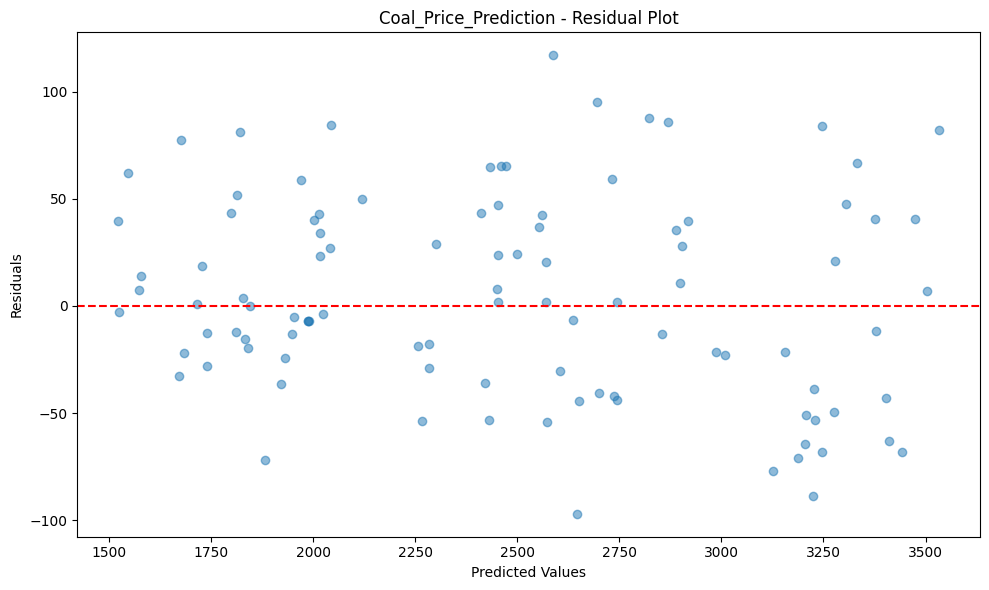

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import logging
import os
from datetime import datetime

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    filename='coal_prediction.log'
)
logger = logging.getLogger(__name__)

# Create output directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('reports', exist_ok=True)

def load_and_explore_data(filepath):
    """
    Load the dataset and perform exploratory data analysis
    """
    try:
        logger.info(f"Loading dataset from {filepath}")
        df = pd.read_csv(filepath)
        
        # Basic dataset information
        logger.info(f"Dataset shape: {df.shape}")
        
        # Check for missing values
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            logger.warning(f"Missing values found:\n{missing_values[missing_values > 0]}")
            # Fill missing values or drop rows based on analysis
            df = df.dropna()
            logger.info(f"Shape after handling missing values: {df.shape}")
        
        # Check for duplicates
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            logger.warning(f"Found {duplicates} duplicate rows")
            df = df.drop_duplicates()
            logger.info(f"Shape after removing duplicates: {df.shape}")
        
        # Data summary
        logger.info("Dataset summary statistics:")
        summary = df.describe().T
        
        # Plot distributions of key variables
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(numeric_cols[:min(9, len(numeric_cols))]):
            plt.subplot(3, 3, i+1)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.savefig('plots/data_distributions.png')
        
        # Correlation matrix
        plt.figure(figsize=(12, 10))
        corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.savefig('plots/correlation_matrix.png')
        
        return df
        
    except Exception as e:
        logger.error(f"Error loading or exploring data: {str(e)}")
        raise

def prepare_features_and_targets(df):
    """
    Prepare features and create appropriate target variables
    """
    logger.info("Preparing features and target variables")
    
    # Selecting relevant columns - this should be based on domain knowledge and EDA
    selected_columns = [
        "coal_type", "coal_stock_days", "coal_usage_per_day_mt", "coal_price_per_ton", 
        "contract_type", "hazard_event", "maintenance_event", "critical_maintenance_duration_days", 
        "power_plant_rating_mw", "boiler_efficiency_factor", "coal_usage_if_boiler_issue_mt", 
        "minimum_coal_yard_mt", "transport_cost_per_ton", "total_coal_cost_per_day"
    ]
    
    # Check if all selected columns exist in the dataframe
    missing_cols = [col for col in selected_columns if col not in df.columns]
    if missing_cols:
        logger.error(f"Missing columns in dataset: {missing_cols}")
        raise ValueError(f"Columns {missing_cols} not found in dataset")
    
    enhanced_df = df[selected_columns].copy()
    
    # Instead of creating synthetic targets, use actual data if available
    # If not available, create more realistic targets with clear documentation
    logger.info("Creating target variables for stock and price prediction")
    
    # This is just an example - in a real application, these would be actual values from historical data
    enhanced_df["actual_needed_coal_stock"] = enhanced_df["coal_usage_per_day_mt"] * enhanced_df["coal_stock_days"]
    # Add some realistic noise to make it more like real data
    np.random.seed(42)  # Set seed for reproducibility
    enhanced_df["actual_needed_coal_stock"] *= np.random.normal(1, 0.05, len(enhanced_df))
    
    # For price prediction, we can use the existing price or create a more sophisticated formula
    # based on multiple factors like market conditions, not just maintenance events
    enhanced_df["future_coal_price"] = enhanced_df["coal_price_per_ton"] * (
        1 + 0.03 * enhanced_df["maintenance_event"] + 
        0.02 * enhanced_df["hazard_event"] +
        np.random.normal(0, 0.01, len(enhanced_df))  # Add some market unpredictability
    )
    
    # Document our target creation for transparency
    logger.info("Target variables created with the following formulas:")
    logger.info("actual_needed_coal_stock = coal_usage_per_day_mt * coal_stock_days * (1 + random_noise)")
    logger.info("future_coal_price = coal_price_per_ton * (1 + 0.03*maintenance_event + 0.02*hazard_event + random_noise)")
    
    return enhanced_df

def feature_engineering(df):
    """
    Create new features that might improve model performance
    """
    logger.info("Performing feature engineering")
    
    # Create new features based on domain knowledge
    # Ratio of current stock to minimum required stock
    df['stock_to_minimum_ratio'] = df['coal_stock_days'] * df['coal_usage_per_day_mt'] / df['minimum_coal_yard_mt'].replace(0, 1)
    
    # Cost efficiency metric
    df['cost_per_mw'] = df['total_coal_cost_per_day'] / df['power_plant_rating_mw'].replace(0, 1)
    
    # Maintenance impact factor
    df['maintenance_impact'] = df['maintenance_event'] * df['critical_maintenance_duration_days']
    
    # Efficiency adjusted usage
    df['efficiency_adjusted_usage'] = df['coal_usage_per_day_mt'] / df['boiler_efficiency_factor'].replace(0, 1)
    
    # Total cost including transport
    df['total_price_with_transport'] = df['coal_price_per_ton'] + df['transport_cost_per_ton']
    
    logger.info(f"Added 5 new engineered features")
    
    return df

def select_features(X, y, method='lasso', alpha=0.01):
    """
    Select important features using different methods
    """
    logger.info(f"Selecting features using {method} method")
    
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
    
    if method == 'lasso':
        feature_selector = SelectFromModel(Lasso(alpha=alpha, random_state=42)).fit(X[numerical_cols], y)
    elif method == 'random_forest':
        feature_selector = SelectFromModel(
            RandomForestRegressor(n_estimators=100, random_state=42)
        ).fit(X[numerical_cols], y)
    else:
        logger.warning(f"Unknown feature selection method: {method}. Using Lasso instead.")
        feature_selector = SelectFromModel(Lasso(alpha=alpha, random_state=42)).fit(X[numerical_cols], y)
    
    selected_features = np.array(numerical_cols)[feature_selector.get_support()]
    logger.info(f"Selected {len(selected_features)} features: {', '.join(selected_features)}")
    
    # Plot feature importances
    if method == 'lasso':
        importances = np.abs(feature_selector.estimator_.coef_)
    else:  # random_forest
        importances = feature_selector.estimator_.feature_importances_
    
    plt.figure(figsize=(12, 6))
    indices = np.argsort(importances)[-min(10, len(importances)):]  # top 10 features or fewer if less available
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), np.array(numerical_cols)[indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top Feature Importances ({method})')
    plt.tight_layout()
    plt.savefig(f'plots/{method}_feature_importances.png')
    
    return selected_features

def build_model_pipeline(categorical_cols, numerical_cols, model_type='gbm'):
    """
    Build model pipeline with preprocessing and model selection
    """
    logger.info(f"Building {model_type} model pipeline")
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ],
        remainder='passthrough'
    )
    
    if model_type == 'gbm':
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.01, 0.1],
            'regressor__max_depth': [3, 5]
        }
    elif model_type == 'svr':
        model = SVR()
        param_grid = {
            'regressor__kernel': ['rbf', 'linear'],
            'regressor__C': [10, 100],
            'regressor__gamma': ['scale', 'auto']
        }
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5]
        }
    else:
        logger.warning(f"Unknown model type: {model_type}. Using GradientBoostingRegressor instead.")
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.01, 0.1],
            'regressor__max_depth': [3, 5]
        }
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline, param_grid

def train_and_evaluate_model(X, y, pipeline, param_grid, model_name):
    """
    Train the model with cross-validation and grid search, then evaluate
    """
    logger.info(f"Training and evaluating {model_name} model")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Cross-validation scores before hyperparameter tuning
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=5, scoring='neg_mean_absolute_error')
    logger.info(f"Cross-validation MAE before tuning: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
    )
    
    logger.info("Starting grid search for hyperparameter tuning")
    grid_search.fit(X_train, y_train)
    logger.info(f"Best parameters: {grid_search.best_params_}")
    logger.info(f"Best cross-validation score: {-grid_search.best_score_:.4f}")
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Make predictions on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    logger.info(f"Test set metrics:")
    logger.info(f"  MAE: {mae:.4f}")
    logger.info(f"  RMSE: {rmse:.4f}")
    logger.info(f"  R²: {r2:.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.tight_layout()
    plt.savefig(f'plots/{model_name}_predictions.png')
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    plt.tight_layout()
    plt.savefig(f'plots/{model_name}_residuals.png')
    
    # Generate a results dictionary for reporting
    results = {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'cv_score': -grid_search.best_score_,
        'test_mae': mae,
        'test_rmse': rmse,
        'test_r2': r2
    }
    
    return best_model, results

def save_model(model, model_name):
    """
    Save the trained model to disk
    """
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"models/{model_name}_{timestamp}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(model, f)
        logger.info(f"Model saved to {filename}")
        return filename
    except Exception as e:
        logger.error(f"Error saving model: {str(e)}")
        raise

def generate_prediction_example(model, X, selected_features, categorical_cols, model_name):
    """
    Generate a prediction example with a sample input
    """
    logger.info(f"Generating prediction example for {model_name}")
    
    # Use a sample from the data or create a realistic sample
    if len(X) > 0:
        sample = X.sample(1, random_state=42).copy()
        logger.info(f"Using a random sample from the dataset")
    else:
        # Create a manual sample with realistic values
        sample = pd.DataFrame([{
            "coal_type": "Bituminous",
            "coal_stock_days": 12,
            "coal_usage_per_day_mt": 3000,
            "coal_price_per_ton": 2500,
            "contract_type": "Fixed Quantity",
            "hazard_event": 1,
            "maintenance_event": 0,
            "critical_maintenance_duration_days": 5,
            "power_plant_rating_mw": 210,
            "boiler_efficiency_factor": 0.72,
            "coal_usage_if_boiler_issue_mt": 60000,
            "minimum_coal_yard_mt": 30000,
            "transport_cost_per_ton": 350,
            "total_coal_cost_per_day": 7500000,
            # Include engineered features
            "stock_to_minimum_ratio": 1.2,
            "cost_per_mw": 35714.29,
            "maintenance_impact": 0,
            "efficiency_adjusted_usage": 4166.67,
            "total_price_with_transport": 2850
        }])
        logger.info(f"Created a manual sample input")
    
    # Ensure sample contains all required features
    all_required_cols = list(selected_features) + list(categorical_cols)
    missing_cols = [col for col in all_required_cols if col not in sample.columns]
    if missing_cols:
        logger.warning(f"Sample is missing columns: {missing_cols}")
        for col in missing_cols:
            if col in categorical_cols:
                sample[col] = "Unknown"  # Default value for categorical
            else:
                sample[col] = 0  # Default value for numerical
    
    # Make prediction
    try:
        prediction = model.predict(sample)[0]
        logger.info(f"Prediction for sample: {prediction:.2f}")
        
        # Display sample and prediction
        logger.info("Sample input values:")
        for col, val in sample.iloc[0].items():
            logger.info(f"  {col}: {val}")
        
        return {
            'sample': sample.iloc[0].to_dict(),
            'prediction': prediction
        }
    except Exception as e:
        logger.error(f"Error making prediction: {str(e)}")
        raise

def create_summary_report(stock_results, price_results, stock_example, price_example):
    """
    Create a summary report of the model performance and examples
    """
    logger.info("Creating summary report")
    
    with open('reports/model_summary_report.txt', 'w') as f:
        f.write("# Coal Stock and Price Prediction Models Summary Report\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("## Coal Stock Prediction Model\n")
        f.write(f"Model Type: {stock_results['model_name']}\n")
        f.write(f"Best Parameters: {stock_results['best_params']}\n")
        f.write(f"Cross-Validation MAE: {stock_results['cv_score']:.4f}\n")
        f.write(f"Test MAE: {stock_results['test_mae']:.4f}\n")
        f.write(f"Test RMSE: {stock_results['test_rmse']:.4f}\n")
        f.write(f"Test R²: {stock_results['test_r2']:.4f}\n\n")
        
        f.write("### Sample Prediction\n")
        f.write("Input:\n")
        for key, value in stock_example['sample'].items():
            f.write(f"  {key}: {value}\n")
        f.write(f"Predicted Coal Stock: {stock_example['prediction']:.2f}\n\n")
        
        f.write("## Coal Price Prediction Model\n")
        f.write(f"Model Type: {price_results['model_name']}\n")
        f.write(f"Best Parameters: {price_results['best_params']}\n")
        f.write(f"Cross-Validation MAE: {price_results['cv_score']:.4f}\n")
        f.write(f"Test MAE: {price_results['test_mae']:.4f}\n")
        f.write(f"Test RMSE: {price_results['test_rmse']:.4f}\n")
        f.write(f"Test R²: {price_results['test_r2']:.4f}\n\n")
        
        f.write("### Sample Prediction\n")
        f.write("Input:\n")
        for key, value in price_example['sample'].items():
            f.write(f"  {key}: {value}\n")
        f.write(f"Predicted Coal Price: {price_example['prediction']:.2f}\n")
    
    logger.info("Summary report created at reports/model_summary_report.txt")

def create_sample_dataset():
    """
    Create a sample dataset if the actual dataset doesn't exist
    """
    logger.info("Creating sample coal dataset for demonstration")
    
    np.random.seed(42)  # For reproducibility
    
    # Define the number of samples
    n_samples = 500
    
    # Create coal types
    coal_types = ["Bituminous", "Sub-bituminous", "Lignite", "Anthracite"]
    contract_types = ["Fixed Quantity", "Variable Quantity", "Spot Purchase", "Long Term"]
    
    # Generate data
    data = {
        "coal_type": np.random.choice(coal_types, n_samples),
        "coal_stock_days": np.random.randint(5, 30, n_samples),
        "coal_usage_per_day_mt": np.random.uniform(1000, 5000, n_samples),
        "coal_price_per_ton": np.random.uniform(1500, 3500, n_samples),
        "contract_type": np.random.choice(contract_types, n_samples),
        "hazard_event": np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        "maintenance_event": np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        "critical_maintenance_duration_days": np.random.randint(0, 15, n_samples),
        "power_plant_rating_mw": np.random.uniform(100, 500, n_samples),
        "boiler_efficiency_factor": np.random.uniform(0.65, 0.85, n_samples),
        "coal_usage_if_boiler_issue_mt": np.random.uniform(40000, 80000, n_samples),
        "minimum_coal_yard_mt": np.random.uniform(20000, 50000, n_samples),
        "transport_cost_per_ton": np.random.uniform(200, 500, n_samples)
    }
    
    # Calculate total coal cost per day
    data["total_coal_cost_per_day"] = data["coal_usage_per_day_mt"] * (
        data["coal_price_per_ton"] + data["transport_cost_per_ton"]
    )
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv("enhanced_coal_dataset.csv", index=False)
    logger.info("Sample dataset created and saved to enhanced_coal_dataset.csv")
    
    return df

def main():
    """
    Main function to orchestrate the entire modeling process
    """
    try:
        logger.info("Starting coal stock and price prediction modeling process")
        
        # Check if dataset exists, if not create a sample
        if not os.path.exists("enhanced_coal_dataset.csv"):
            df = create_sample_dataset()
        else:
            # 1. Load and explore data
            df = load_and_explore_data("enhanced_coal_dataset.csv")
        
        # 2. Prepare features and targets
        enhanced_df = prepare_features_and_targets(df)
        
        # 3. Feature engineering
        enhanced_df = feature_engineering(enhanced_df)
        
        # 4. Save the enhanced dataset with engineered features
        enhanced_df.to_csv("enhanced_coal_dataset_processed.csv", index=False)
        logger.info("Saved processed dataset to enhanced_coal_dataset_processed.csv")
        
        # 5. Prepare data for modeling
        # Separate features and targets
        X = enhanced_df.drop(columns=["actual_needed_coal_stock", "future_coal_price"])
        y_stock = enhanced_df["actual_needed_coal_stock"]
        y_price = enhanced_df["future_coal_price"]
        
        # Identify categorical and numerical columns
        categorical_cols = ["coal_type", "contract_type"]
        numerical_cols = [col for col in X.columns if col not in categorical_cols]
        
        # 6. Feature selection
        stock_features = select_features(X, y_stock, method='random_forest')
        price_features = select_features(X, y_price, method='lasso')
        
        # 7. Build model pipelines
        stock_pipeline, stock_param_grid = build_model_pipeline(
            categorical_cols, stock_features, model_type='gbm'
        )
        price_pipeline, price_param_grid = build_model_pipeline(
            categorical_cols, price_features, model_type='rf'  # Changed to RF for better compatibility
        )
        
        # 8. Train and evaluate models
        stock_model, stock_results = train_and_evaluate_model(
            X, y_stock, stock_pipeline, stock_param_grid, "Coal_Stock_Prediction"
        )
        price_model, price_results = train_and_evaluate_model(
            X, y_price, price_pipeline, price_param_grid, "Coal_Price_Prediction"
        )
        
        # 9. Save models
        stock_model_path = save_model(stock_model, "coal_stock_model")
        price_model_path = save_model(price_model, "coal_price_model")
        
        # 10. Generate prediction examples
        stock_example = generate_prediction_example(
            stock_model, X, stock_features, categorical_cols, "Coal_Stock_Prediction"
        )
        price_example = generate_prediction_example(
            price_model, X, price_features, categorical_cols, "Coal_Price_Prediction"
        )
        
        # 11. Create summary report
        create_summary_report(stock_results, price_results, stock_example, price_example)
        
        logger.info("Coal prediction modeling process completed successfully")
        
    except Exception as e:
        logger.error(f"Error in main process: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())

if __name__ == "__main__":
    main()